In [1]:
# %matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

## Funciones generales

In [2]:
#Da el espectro identificando los primeros máximos sin analizar
def Spectrum(datax,datay,intensity,num):
    marker_x = []
    marker_y = []
    index_y = []
    index_x = []
    anotaciones = []

    for i in range(0,len(datax)):
        mark = i

        if mark != 0 and mark != len(datax)-1:
            last = datay[mark - 1]
            next = datay[mark + 1]

            #Hallar máximos de espectro
            if (last < datay[i]) and (next < datay[i]) and (datay[i]>intensity):
                marker_x.append(datax[i])
                marker_y.append(datay[i])

                index_y.append( datay[i-num:i+num] )
                index_x.append( datax[i-num:i+num] )

                anotaciones.append(str(datax[i]))
                
    return marker_x,marker_y,index_x,index_y,anotaciones


#Procesa el archivo txt de datos, inten se refiere a la intensidad mínima para buscar y num a la cantidad de puntos alrededor de la lorentziana
def DataProcess(l,inten,num):
    data = pd.read_csv(l, delimiter=' ')
    pixel = np.array(data['P'])
    intensidad = np.array(data['I'])

    marker_x,marker_y, index_x,index_y,anotaciones = Spectrum(pixel,intensidad,inten,num)
    
    return pixel,intensidad,marker_x,marker_y, index_x,index_y,anotaciones


#Retira aquellas líneas que no aparecen en el catálogo o no ayudan a la obtención de la lorentziana
def DataCatalogue(pixs,marker_x,marker_y, index_x,index_y,anotaciones):
    mar_x = []
    mar_y = []
    ind_y = []
    ind_x = []
    anot = []
   

    for i in range(0,len(marker_x)):
        if marker_x[i] not in pixs:
            mar_x.append(marker_x[i])
            mar_y.append(marker_y[i])
            ind_x.append(index_x[i])
            ind_y.append(index_y[i])
            anot.append(anotaciones[i])

    return mar_x,mar_y, ind_x,ind_y,anot


#Función Lorentziana
def Lorentzian(x,h,x0,W):
    return h*W**2/((x-x0)**2+W**2)


#Realiza el ajuste Lorentziano sobre el espectro catalogado
def AjusteLorentz(i,index_x, index_y):
    x = index_x[i]
    y = index_y[i] 
    x_1 = np.linspace(x[0],x[-1],500 )

    popt, _ = curve_fit(Lorentzian,x,y) 
    h = popt[0]
    x0 = popt[1]
    w = popt[2]

    fit_y= Lorentzian(x_1,h,x0,w)

    return x0,h,fit_y,x_1, x, y


#Devuelve el DataFrame con los píxeles calculados
def MakeDataFrame(rango,catalog_long,index_x, index_y):

    Datafit = pd.DataFrame()
    lineasfit = []
    alturafit = []

    for i in range(0,rango):
        linea,altura, fity, fitx, x, y = AjusteLorentz(i,index_x, index_y)
        lineasfit.append(linea)
        alturafit.append(altura)
    

    Datafit['Pixel'] = lineasfit
    Datafit['Intensidad'] = alturafit
    Datafit['Catalogo longitud'] = catalog_long

    return Datafit

#Obtener la regresion lineal
def LinearFit(datax,datay,n):
    param = np.polyfit(datax,datay, n)
    xm = np.linspace(min(datax),max(datax),len(datax))
    ym = np.polyval(param, xm)
    xres = datax
    ye = np.polyval(param, datax)
    res = ye - datay

    return ym,xm,res,xres,param

#Obtener la calibración de las lineas sospechosas
def LineasSus(pixs,param):
    Data = pd.DataFrame()
    Data['Pixel'] = pixs
    Orden1 = []
    Orden2 = []
    Orden3 = []
    for i in pixs:
        Orden1.append(np.polyval(param,i)*2)
        Orden2.append(np.polyval(param,i)) 
        Orden3.append(np.polyval(param,i)*(2/3)) 
    
    Data['Calibracion orden 1'] = Orden1
    Data['Calibracion orden 2'] = Orden2
    Data['Calibracion orden 3'] = Orden3

    return Data

#Convertir DataFrame a tabla de Latex
# print(DataFit_1.to_latex(index=False))

# Linea para guardar la imagen de un fig
#fig2.savefig('th 6200 orden 2 espectro tratado.jpg')

## Análisis

### Para intensidades grandes >575

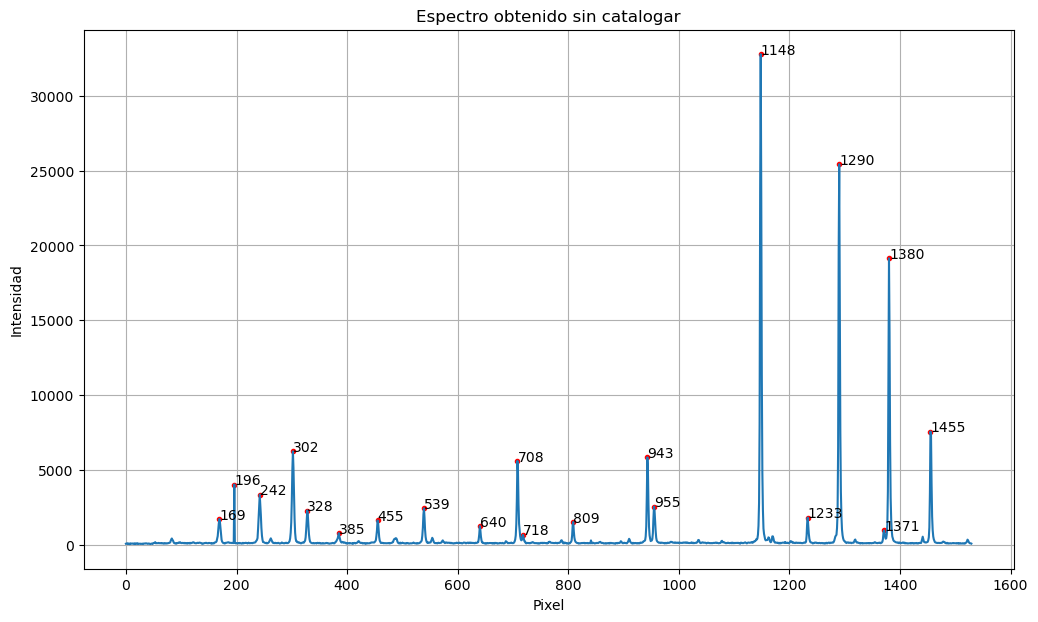

In [3]:
pixel,intensidad,marker_x,marker_y, index_x,index_y,anotaciones = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6565\th 6565 orden 2 spec.txt", 575, 7)

#Grafica para ver el espectro completo y cuadrar hasta qué intensidad mirar
fig1, ax1 = plt.subplots(1,1, figsize=(12,7))
ax1.plot(pixel,intensidad)
ax1.scatter(marker_x,marker_y,marker='.',color = 'red')
ax1.set_title('Espectro obtenido sin catalogar')
ax1.set_xlabel('Pixel')
ax1.set_ylabel('Intensidad')
ax1.grid()
for i, label in enumerate(anotaciones):
    plt.annotate(label, (marker_x[i] + 0.1, marker_y[i]))

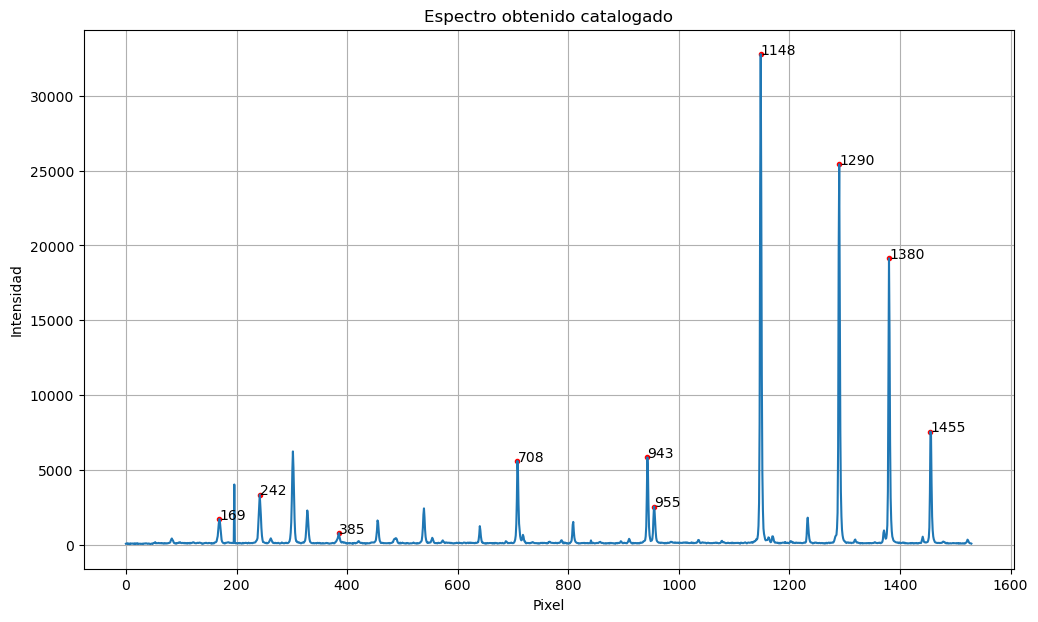

In [4]:
#Lista de pixeles que se descartan al no estar en el espectro
Pixnon_1 = [196, 302,328,455, 539, 640, 809, 718, 1233, 1371]

#Se obtiene el espectro limpio sin los píxeles diferentes
marker_xl,marker_yl, index_xl,index_yl,anotacionesl = DataCatalogue(Pixnon_1,marker_x,marker_y, index_x,index_y,anotaciones)
    
#Grafica del espectro sin las líneas que no pertenecen  
fig2, ax2 = plt.subplots(1,1, figsize=(12,7))
ax2.plot(pixel,intensidad)
ax2.scatter(marker_xl,marker_yl,marker='.',color = 'red')
ax2.set_title('Espectro obtenido catalogado')
ax2.set_xlabel('Pixel')
ax2.set_ylabel('Intensidad')
ax2.grid()
for i, label in enumerate(anotacionesl):
    plt.annotate(label, (marker_xl[i] + 0.1, marker_yl[i]))


In [5]:
#Longitudes de onda observadas en el catalogo de los píxeles que sí se lograron ver, ingreso manual
catalog_long_1 = [6551.705, 6554.160, 6558.875, 6569.632, 6577.213, 6577.656, 6583.906, 6588.539, 6591.484, 6593.939]

#Lista de líneas sospechosas que sí están en el espectro pero no catalogadas
Pixesp_1 = [539]

#Lista de líneas completamente sospechosas 
Pixsus_1 = [196,302,328, 455, 640, 809, 1233]

#Unir dataframes de líneas en el catalogo
DataFit_1 = MakeDataFrame(len(marker_xl),catalog_long_1,index_xl, index_yl)
DataFit_1

,Pixel,Intensidad,Catalogo longitud
0,169.109791,1787.289390,6551.705
1,242.064134,3384.426104,6554.160
2,384.794436,699.944129,6558.875
3,708.405532,6000.588168,6569.632
4,943.369154,6327.962921,6577.213
5,955.400428,2676.776012,6577.656
6,1148.053822,34273.594017,6583.906
7,1289.908924,26686.591664,6588.539
8,1380.209971,20088.799058,6591.484
9,1455.537650,8741.711485,6593.939


### Para líneas con intensidades pequeñas < 525

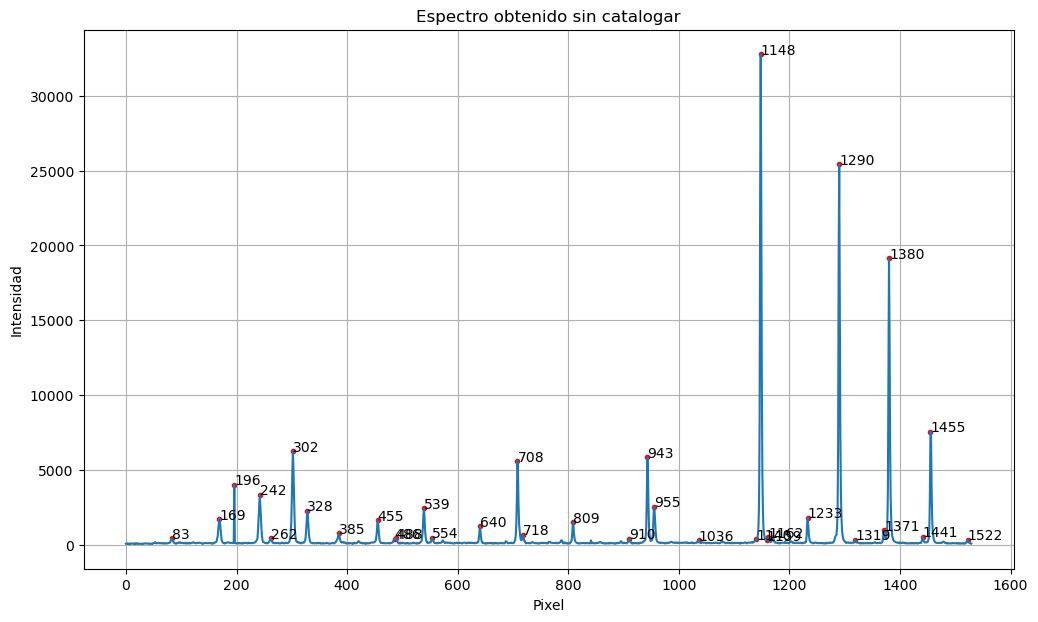

In [6]:
pixel,intensidad,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6565\th 6565 orden 2 spec.txt", 325, 10)

#Grafica para ver el espectro completo y cuadrar hasta qué intensidad mirar
fig1, ax1 = plt.subplots(1,1, figsize=(12,7))
ax1.plot(pixel,intensidad)
ax1.scatter(marker_x_,marker_y_,marker='.',color = 'red')
ax1.set_title('Espectro obtenido sin catalogar')
ax1.set_xlabel('Pixel')
ax1.set_ylabel('Intensidad')
ax1.grid()
for i, label in enumerate(anotaciones_):
    plt.annotate(label, (marker_x_[i] + 0.1, marker_y_[i]))

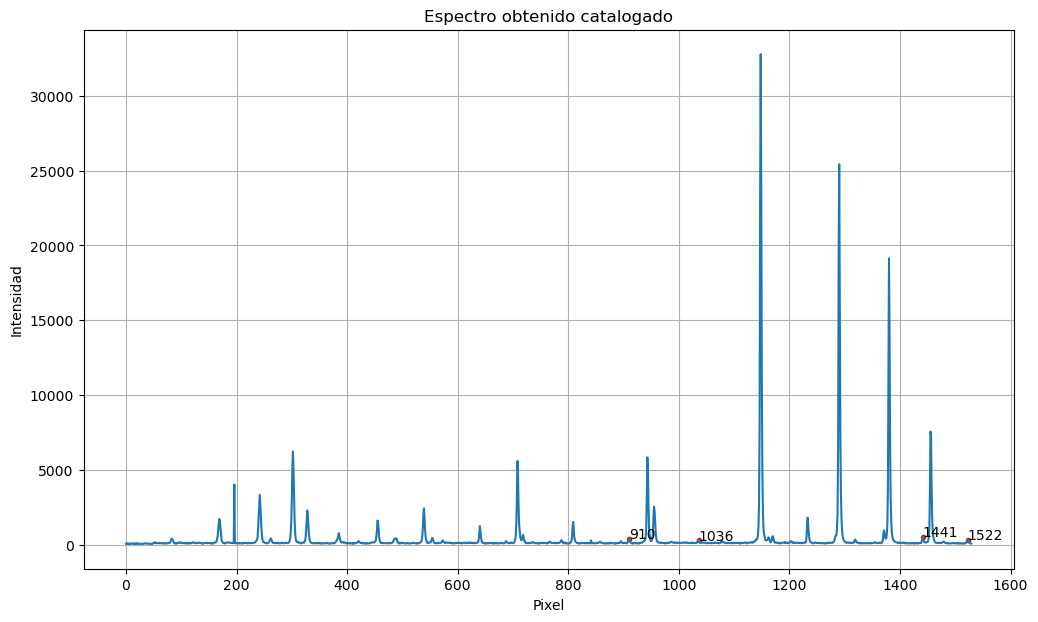

In [7]:
#Lineas que no aportan al análisis o ya se analizaron
Pixnon_2 = [83,169,196,242,262,302,328,385,455,486,488,539,554,640,708,718,809,943,955,1140, 1148,1159, 1162,1233,1290,1319,1371,1380,1455] 
#Se obtiene el espectro limpio sin los píxeles diferentes
marker_xl_,marker_yl_, index_xl_,index_yl_,anotacionesl_ = DataCatalogue(Pixnon_2,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)
    
#Grafica del espectro sin las líneas que no pertenecen  
fig2, ax2 = plt.subplots(1,1, figsize=(12,7))
ax2.plot(pixel,intensidad)
ax2.scatter(marker_xl_,marker_yl_,marker='.',color = 'red')
ax2.set_title('Espectro obtenido catalogado')
ax2.set_xlabel('Pixel')
ax2.set_ylabel('Intensidad')
ax2.grid()
for i, label in enumerate(anotacionesl_):
    plt.annotate(label, (marker_xl_[i] + 0.1, marker_yl_[i]))


In [8]:
#Longitudes de onda observadas en el catalogo de los píxeles que sí se lograron ver, ingreso manual
catalog_long_2 = [6576.122, 6580.229, 6593.939,6596.100]

#Lista de líneas sospechosas que sí están en el espectro pero no catalogadas
Pixesp_2 = [554 ]

#Lista de líneas completamente sospechosas 
Pixsus_2 = [83,262]

#Unir dataframes de líneas en el catalogo
# DataFit_2 = MakeDataFrame(len(marker_xl_),catalog_long_2,index_xl_, index_yl_)
# DataFit_2
#Es necesario revisarlas una por una

#### Lineas para analizar individualmente

In [9]:
#NO CONFUNDIR, son lineas ya analizadas, es para poder hacer un análisis más detallado a las lineas que por la intensidad toca separarlas del análisis general
pixsus = Pixnon_2 + [ 1036, 1441, 1522]

pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6565\th 6565 orden 2 spec.txt",325,8)
marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(pixsus,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)

catalog_long_2 = [6576.122]

DataFit_21 = MakeDataFrame(len(marker_x_),catalog_long_2,index_x_,index_y_)
DataFit_21

,Pixel,Intensidad,Catalogo longitud
0,910.076805,357.999332,6576.122


In [10]:
#NO CONFUNDIR, son lineas ya analizadas, es para poder hacer un análisis más detallado a las lineas que por la intensidad toca separarlas del análisis general
pixsus = Pixnon_2 + [910 , 1441, 1522]

pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6565\th 6565 orden 2 spec.txt",325,6)
marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(pixsus,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)

catalog_long_2 = [6580.229]

DataFit_22 = MakeDataFrame(len(marker_x_),catalog_long_2,index_x_,index_y_)
DataFit_22

,Pixel,Intensidad,Catalogo longitud
0,1035.438219,306.673572,6580.229


In [11]:
# #NO CONFUNDIR, son lineas ya analizadas, es para poder hacer un análisis más detallado a las lineas que por la intensidad toca separarlas del análisis general
# pixsus = Pixnon_2 + [910 , 1306, 1522]

# pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6565\th 6565 orden 2 spec.txt",325,1)
# marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(pixsus,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)

# catalog_long_2 = [6593.939]

# DataFit_22 = MakeDataFrame(len(marker_x_),catalog_long_2,index_x_,index_y_)

# Se descarta por la cercanía a la otra línea

In [12]:
# #NO CONFUNDIR, son lineas ya analizadas, es para poder hacer un análisis más detallado a las lineas que por la intensidad toca separarlas del análisis general
# pixsus = Pixnon_2 + [910 , 1441, 1306]

# pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6565\th 6565 orden 2 spec.txt",325,21)
# marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(pixsus,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)

# catalog_long_2 = [6596.100]

# DataFit_23 = MakeDataFrame(len(marker_x_),catalog_long_2,index_x_,index_y_)
# DataFit_23

# Se descarta por la poca cantidad de puntos

#### Lineas especiales

In [13]:
# # Solo descomentar si es necesario un análisis con gráfica para ver el ajuste
# pixsus = [] #lineas ya analizadas

# pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\th 6200 orden 2 spec.txt",275,18)
# marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(pixsus,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)


# def MakeDataFrame(rango,catalog_long,index_x_,index_y_):

#     Datafit = pd.DataFrame()
#     lineasfit = []
#     alturafit = []

#     for i in range(0,rango):
#         linea,altura, fity, fitx, x, y = AjusteLorentz(i,index_x_,index_y_)
#         lineasfit.append(linea)
#         alturafit.append(altura)
    

#     Datafit['Pixel'] = lineasfit
#     Datafit['Intensidad'] = alturafit
#     Datafit['Catalogo longitud'] = catalog_long

#     return Datafit, fity, fitx, x, y

# catalog_long_2 = []
# DataFit_2, fity, fitx, x, y = MakeDataFrame(len(marker_x_),catalog_long_2,index_x_,index_y_)

# fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.scatter(x,y)

### Unir todo en un dataframe

In [14]:
DataFit = pd.concat([DataFit_1,DataFit_21,DataFit_22], axis=0).sort_values(by='Pixel', ascending=True, na_position='first').reset_index(drop=True)
DataFit 

,Pixel,Intensidad,Catalogo longitud
0,169.109791,1787.289390,6551.705
1,242.064134,3384.426104,6554.160
2,384.794436,699.944129,6558.875
3,708.405532,6000.588168,6569.632
4,910.076805,357.999332,6576.122
5,943.369154,6327.962921,6577.213
6,955.400428,2676.776012,6577.656
7,1035.438219,306.673572,6580.229
8,1148.053822,34273.594017,6583.906
9,1289.908924,26686.591664,6588.539


### Gráfica del espectro con las líneas encontradas

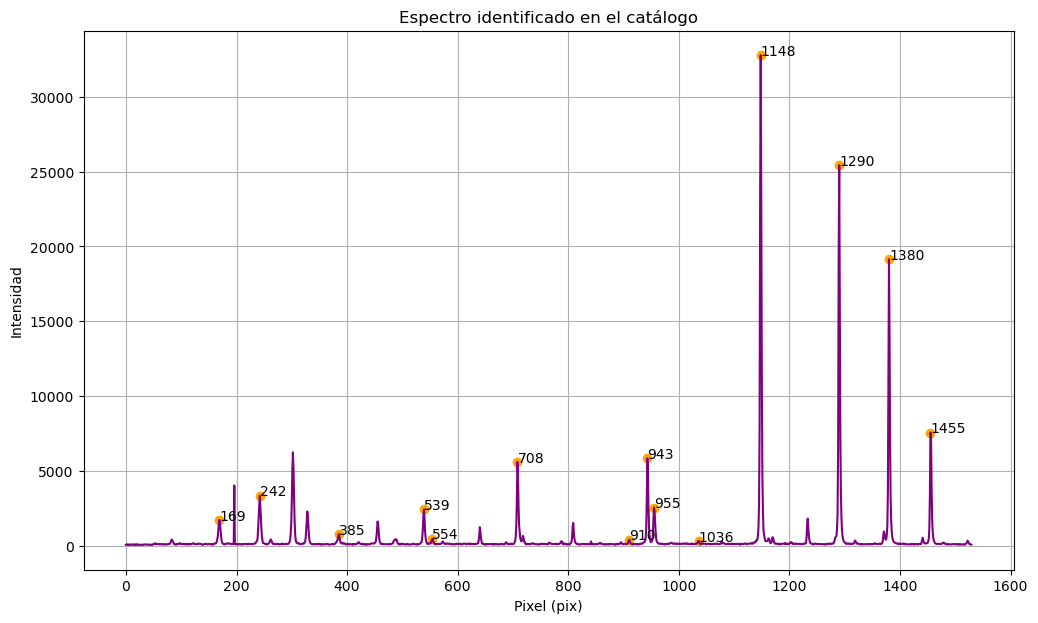

In [15]:
#Solo utilizar al final cuando ya se esté segura del análisis
Pixnon = [83,196,262,302,328,455,486,488,640,718,809,1140,1159, 1162,1233,1319,1371,1441,1522] 


pixel,intensidad,marker_x,marker_y, index_x,index_y,anotaciones = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6565\th 6565 orden 2 spec.txt", 325, 10)
markerx,markery, indexx,indexy,anotaciones = DataCatalogue(Pixnon ,marker_x,marker_y, index_x,index_y,anotaciones)

#Grafica con aquellas encontradas
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.plot(pixel,intensidad, color='purple')
ax.scatter(markerx,markery,color = 'orange')
ax.set_title('Espectro identificado en el catálogo')
ax.set_xlabel('Pixel (pix)')
ax.set_ylabel('Intensidad')
ax.grid()
for i, label in enumerate(anotaciones):
    plt.annotate(label, (markerx[i] + 0.1, markery[i]))

#fig.savefig('th 6565 espectro tratado.pdf')

### Regresión lineal de todos los puntos

[-2.83327741e-15  1.18737404e-11 -1.78728514e-08  1.11952916e-05
  3.03730644e-02  6.54633806e+03]


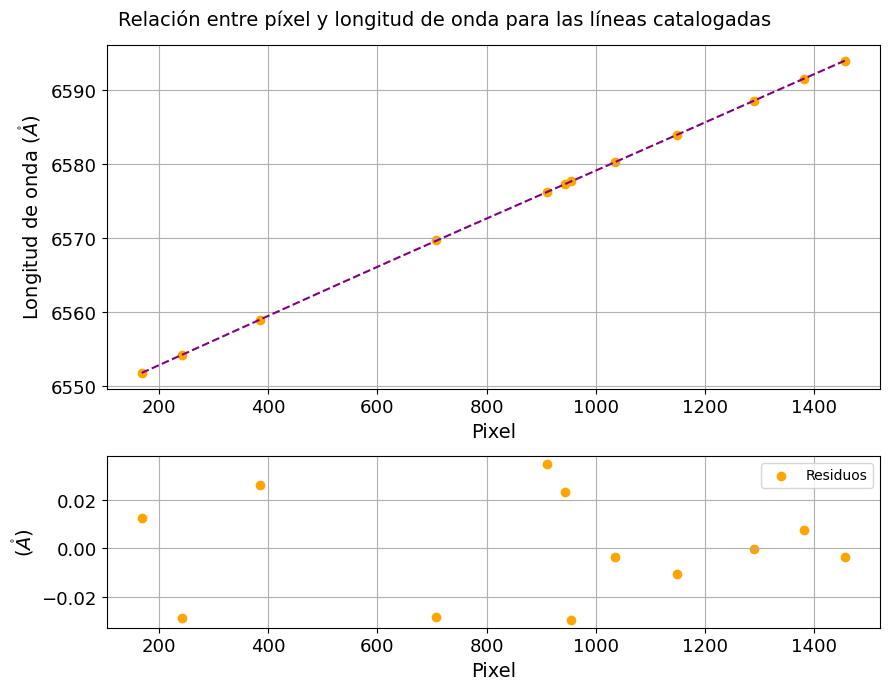

In [16]:
ym,_x,res,xres,param = LinearFit(DataFit['Pixel'],DataFit['Catalogo longitud'], 5) 

#Gráfico con residuos
fig3, axis3 = plt.subplots(2,1, figsize = (9, 7), gridspec_kw = {"height_ratios":[2, 1]})
ax1 = axis3[0]
ax2 = axis3[1]

fig3.suptitle(r'Relación entre píxel y longitud de onda para las líneas catalogadas',fontsize=14)

ax1.scatter(DataFit['Pixel'],DataFit['Catalogo longitud'], color='orange')
ax1.plot(_x,ym,'--',color='purple')
ax1.set_ylabel(r"Longitud de onda $(\mathring{A})$",fontsize=14)
ax1.set_xlabel(r'Pixel',fontsize=14)
ax1.grid()
ax1.tick_params(axis='both',labelsize=13)

ax2.scatter(xres,res,label = 'Residuos',color='orange')
ax2.grid()
ax2.tick_params(axis='both',labelsize=13)
ax2.legend()
ax2.set_xlabel(r'Pixel',fontsize=14)
ax2.set_ylabel(r'$(\mathring{A})$',fontsize=14)

fig3.tight_layout()
#fig3.savefig('th 6565 regresion lineal.pdf')
print(param)

### Análisis líneas sospechosas y que no aparecen en el catalogo

In [17]:
#Ver y tener los diferentes valores encontrados en el catalogo de nist
LineasSos_1 = LineasSus(Pixsus_1,param)
LineasSos_2 = LineasSus(Pixsus_2 ,param)

LineasSos = pd.concat([LineasSos_1,LineasSos_2], axis=0).sort_values(by='Pixel', ascending=True, na_position='first').reset_index(drop=True)

LineasSos['Catalogo longitud orden 1'] = [None,None,None, 13112.2961,13115.842, None,13134.2157,13145.91179,13173.5787]
LineasSos['Elemento orden 1'] = [None, None, None, 'Th I', 'Th I',None, 'Th I','Th II','Fe II']
LineasSos['Residuos orden 1'] = LineasSos['Calibracion orden 1']  -LineasSos['Catalogo longitud orden 1']
LineasSos['Catalogo longitud orden 3'] = [4365.93001,4368.43,4369.87567,4370.773,4371.3576,4374.12377,4378.17678,4381.86008,4391.11045]
LineasSos['Elemento orden 3'] = ['Th I','Nb I','Th I','Th II','Th I','Th I','Th I','Th II','Th II']
LineasSos['Residuos orden 3'] = LineasSos['Calibracion orden 3']  -LineasSos['Catalogo longitud orden 3']
LineasSos

,Pixel,Calibracion orden 1,Calibracion orden 2,Calibracion orden 3,Catalogo longitud orden 1,Elemento orden 1,Residuos orden 1,Catalogo longitud orden 3,Elemento orden 3,Residuos orden 3
0,83,13097.852970,6548.926485,4365.950990,NaN,None,NaN,4365.93001,Th I,0.020980
1,196,13105.206784,6552.603392,4368.402261,NaN,None,NaN,4368.43000,Nb I,-0.027739
2,262,13109.590618,6554.795309,4369.863539,NaN,None,NaN,4369.87567,Th I,-0.012131
3,302,13112.262304,6556.131152,4370.754101,13112.29610,Th I,-0.033796,4370.77300,Th II,-0.018899
4,328,13114.001696,6557.000848,4371.333899,13115.84200,Th I,-1.840304,4371.35760,Th I,-0.023701
5,455,13122.491209,6561.245604,4374.163736,NaN,None,NaN,4374.12377,Th I,0.039966
6,640,13134.730035,6567.365018,4378.243345,13134.21570,Th I,0.514335,4378.17678,Th I,0.066565
7,809,13145.755980,6572.877990,4381.918660,13145.91179,Th II,-0.155810,4381.86008,Th II,0.058580
8,1233,13173.348817,6586.674409,4391.116272,13173.57870,Fe II,-0.229883,4391.11045,Th II,0.005822


In [18]:
# Por si se necesita quitar algun elemento None del dataframe .drop([2],axis=0).reset_index(drop=True)
LineasSos['Longitud catálogo'] = LineasSos['Catalogo longitud orden 3']
LineasSos['Elemento'] = LineasSos['Elemento orden 3']
LineasSos['Longitud Calculada'] = LineasSos['Calibracion orden 3']
LineasSos = LineasSos.drop(['Residuos orden 1','Residuos orden 3','Catalogo longitud orden 1','Catalogo longitud orden 3', 'Calibracion orden 1', 'Calibracion orden 3','Elemento orden 1','Elemento orden 3', 'Calibracion orden 2'], axis=1)

LineasSos
#Código para imprimir la tabla de latex
print(LineasSos.to_latex(index=False))

\begin{tabular}{rrlr}
\toprule
Pixel & Longitud catálogo & Elemento & Longitud Calculada \\
\midrule
83 & 4365.930010 & Th I & 4365.950990 \\
196 & 4368.430000 & Nb I & 4368.402261 \\
262 & 4369.875670 & Th I & 4369.863539 \\
302 & 4370.773000 & Th II & 4370.754101 \\
328 & 4371.357600 & Th I & 4371.333899 \\
455 & 4374.123770 & Th I & 4374.163736 \\
640 & 4378.176780 & Th I & 4378.243345 \\
809 & 4381.860080 & Th II & 4381.918660 \\
1233 & 4391.110450 & Th II & 4391.116272 \\
\bottomrule
\end{tabular}



In [19]:
#Lineas que aparecen en el espectro y no son sospechosas
LineasSos_1_ = LineasSus(Pixesp_1,param)
LineasSos_2_ = LineasSus(Pixesp_2,param)
LineasSos_ = pd.concat([LineasSos_1_,LineasSos_2_], axis=0).sort_values(by='Pixel', ascending=True, na_position='first').reset_index(drop=True)
LineasSos_['Longitud Calculada'] = LineasSos_['Calibracion orden 2'] 
LineasSos_ = LineasSos_.drop(['Calibracion orden 2', 'Calibracion orden 1', 'Calibracion orden 3'],axis=1)

LineasSos_

#Código para imprimir la tabla de latex
print(LineasSos_.to_latex(index=False))

\begin{tabular}{rr}
\toprule
Pixel & Longitud Calculada \\
\midrule
539 & 6564.036167 \\
554 & 6564.532428 \\
\bottomrule
\end{tabular}



### Revisar residuos de lineas sospechosas

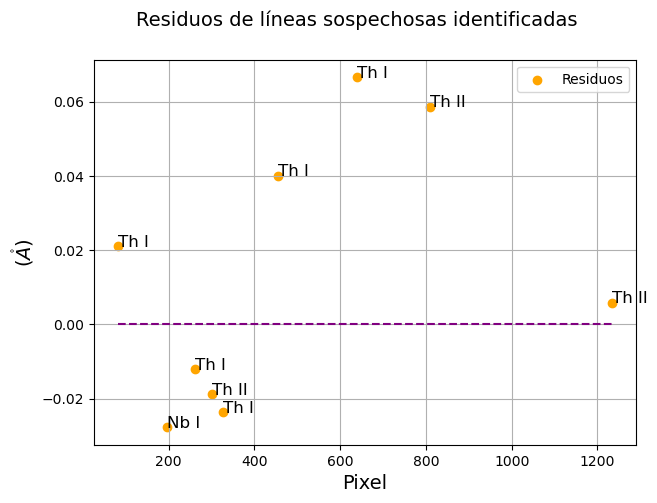

In [20]:
#Calcular residuos de las líneas sospechosas
nist = LineasSos['Longitud catálogo']
calc = LineasSos['Longitud Calculada']
residuos = calc - nist

pixel = LineasSos['Pixel']

#Etiquetas de elementos
label = [each for each in LineasSos['Elemento']]

#Gráfico con residuos
figr, axr = plt.subplots(1,1, figsize=(7,5))

figr.suptitle(r'Residuos de líneas sospechosas identificadas',fontsize=14)

axr.scatter(pixel,residuos,label = 'Residuos',color='orange')
axr.plot(pixel,np.linspace(0,0,len(residuos)),'--',color='purple')
axr.grid()
axr.legend()
axr.set_xlabel(r'Pixel',fontsize=14)
axr.set_ylabel(r'$(\mathring{A})$',fontsize=14)

for j in range (0, len(label)):
    plt.annotate(label[j], (pixel[j], residuos[j]),fontsize=12)

#figr.savefig('th 6565 residuos.pdf')